## Manipulation MLFlow avec ScikitLearn 

Dans cet atelier nous allons utiliser la dataset credit card fraud detection: https://www.kaggle.com/mlg-ulb/creditcardfraud



In [1]:
import numpy as np
import pandas as pd
import matplotlib #
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn #
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, RocCurveDisplay,confusion_matrix
from sklearn.model_selection import KFold
import mlflow
import mlflow.sklearn
print("Numpy: {}".format(np.__version__))
print("Pandas: {}".format(pd.__version__))
print("matplotlib: {}".format(matplotlib.__version__))
print("seaborn: {}".format(sns.__version__))
print("Scikit-Learn: {}".format(sklearn.__version__))
print("MLFlow: {}".format(mlflow.__version__))

Numpy: 1.23.5
Pandas: 2.0.1
matplotlib: 3.7.1
seaborn: 0.12.2
Scikit-Learn: 1.3.1
MLFlow: 2.7.1


c:\Users\acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\pydantic\_internal\_fields.py:149: UserWarning: Field "model_server_url" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
c:\Users\acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\pydantic\_internal\_config.py:321: UserWarning: Valid config keys have changed in V2:
* 'schema_extra' has been renamed to 'json_schema_extra'
  warnings.warn(message, UserWarning)


In [2]:
#mlflow.set_tracking_uri("http://localhost:1234")

In [3]:
data_path = "data/creditcard.csv"
df = pd.read_csv(data_path)
df = df.drop("Time", axis=1) # cette colonne qui n'apporte rien à notre analyse 

In [4]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


<Axes: xlabel='Class', ylabel='count'>

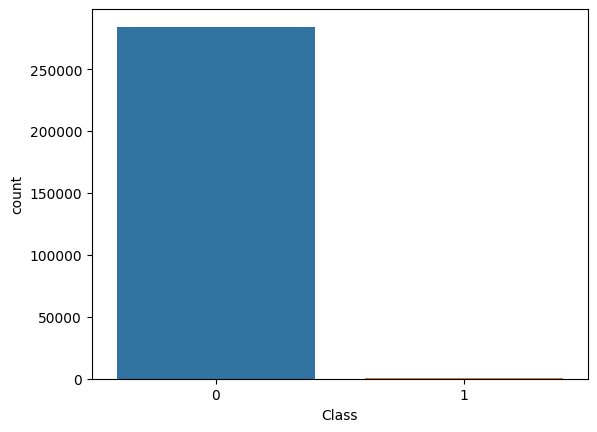

In [5]:
sns.countplot(x='Class',data=df)

As you can notice it, we are processing a very imbalanced dataset. we will consider this in our preprocessing  

Nous allons découper maintenant ce dataset en deux portions (normal and anomaly) frac pour avoir le pourcentage à retenir (ici 50% d'une façon aléatoire d'ou l'utilisation de sample)

In [6]:
normal = df[df.Class == 0].sample(frac=0.5,random_state=2020).reset_index(drop=True)
anomaly = df[df.Class == 1]

In [7]:
print(f"Normal: {normal.shape}")
print(f"Anomaly: {anomaly.shape}")

Normal: (142158, 30)
Anomaly: (492, 30)


Here we are going to split our daatset into train, test, validate subsets 

In [8]:
    normal_train, normal_test = train_test_split(normal,test_size = 0.2, random_state = 2020)
    anomaly_train, anomaly_test = train_test_split(anomaly, test_size = 0.2, random_state = 2020)
    normal_train, normal_validate = train_test_split(normal_train,test_size = 0.25, random_state = 2020)
    anomaly_train, anomaly_validate = train_test_split(anomaly_train, test_size = 0.25, random_state = 2020)

In [9]:
x_train = pd.concat((normal_train, anomaly_train))
x_test = pd.concat((normal_test, anomaly_test))
x_validate = pd.concat((normal_validate, anomaly_validate))

In [10]:
y_train = np.array(x_train["Class"])
y_test = np.array(x_test["Class"])
y_validate = np.array(x_validate["Class"])

In [11]:
x_train = x_train.drop("Class", axis=1)
x_test = x_test.drop("Class", axis=1)
x_validate = x_validate.drop("Class", axis=1)

In [12]:
print("Training sets:\nx_train: {} \ny_train:{}".format(x_train.shape, y_train.shape))
print("\nTesting sets:\nx_test: {} \ny_test:{}".format(x_test.shape, y_test.shape))
print("\nValidation sets:\nx_validate: {} \ny_validate: {}".format(x_validate.shape, y_validate.shape))

Training sets:
x_train: (85588, 29) 
y_train:(85588,)

Testing sets:
x_test: (28531, 29) 
y_test:(28531,)

Validation sets:
x_validate: (28531, 29) 
y_validate: (28531,)


we are using standardscaler to scale ouur data 

In [13]:
scaler = StandardScaler()
scaler.fit(pd.concat((normal, anomaly)).drop("Class", axis=1))

StandardScaler()

In [14]:
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
x_validate = scaler.transform(x_validate)

### l'entrainement et lavalidation en utilisant MLFlow

Nous allons maintennat entrainer et évaluer notre modèle en utilisant MLFlow. 
pour des fins d'organisation de notre code, nous allons procéder en créant des fonctions 

In [15]:
def evaluate(sk_model, x_test, y_test):
    eval_acc = sk_model.score(x_test, y_test)
    preds = sk_model.predict(x_test)
    auc_score = roc_auc_score(y_test, preds)
    mlflow.log_metric("eval_acc", eval_acc) # nous avons fait la même chose pour l'accuracy de test (evaluation)
    mlflow.log_metric("auc_score", auc_score)# aussi pour l'AUC score 
    print(f"Auc Score: {auc_score:.3%}")
    print(f"Eval Accuracy: {eval_acc:.3%}")
    #roc_plot = RocCurveDisplay.plot(sk_model, x_test, y_test)
    #plot_roc_curve(sk_model, x_test, y_test,name='Scikit-learn ROC Curve')
    #plt.savefig("sklearn_roc_plot.png")
    #plt.show()
    plt.clf()
    conf_matrix = confusion_matrix(y_test, preds)
    ax = sns.heatmap(conf_matrix, annot=True,fmt='g')
    ax.invert_xaxis()
    ax.invert_yaxis()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title("Confusion Matrix")
    plt.savefig("sklearn_conf_matrix.png")
    # nous avons dit à MLflow de sauvegarder ces deux figure afin de les consulter à chaque 
    # exécution d'une façon organisée comme nous allons le voir plus loin dans cet atelier  
    #mlflow.log_artifact("sklearn_roc_plot.png")
    mlflow.log_artifact("sklearn_conf_matrix.png")

### Logging and viewing MLflow Runs 

Now, we will assembly what we have done so far.

we will set the experiment name, defining our model, and starting the Mlflow run.

En pratque, tout se passe entre start_run() et end_run()

mlflow.sklearn.log_model(sk_model, "log_reg_model"): ici nous sauvegardons le modèle

mlflow.active_run().info.run_uuid: l'ID de l'experimentation en cours 

2024/01/07 15:27:58 INFO mlflow.tracking.fluent: Experiment with name 'scikit_learn_experiment' does not exist. Creating a new experiment.


Train Accuracy: 99.893%
Auc Score: 85.341%
Eval Accuracy: 99.874%
Model run:  5c764a16f0a148b397bd651c80bb0dc8


c:\Users\acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


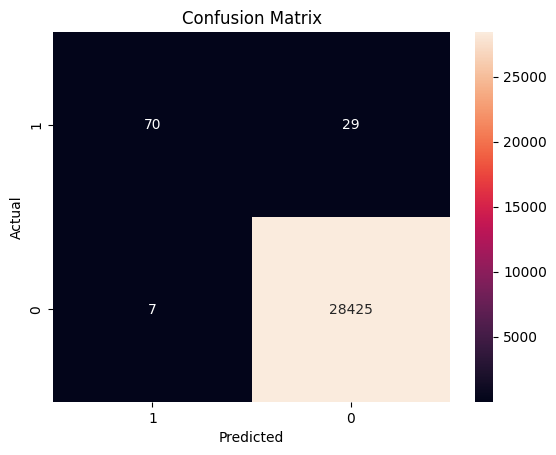

In [16]:
sk_model = LogisticRegression(random_state=None)
mlflow.set_experiment("scikit_learn_experiment")
with mlflow.start_run():
    #train(sk_model, x_train, y_train)
    params = {
    "max_iter": 1,
    "penalty" : 'L1',
    "solver": 'liblinear', #solver{‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’}, default=’lbfgs’
    }
    mlflow.log_params(params)
    sk_model = sk_model.fit(x_train, y_train)
    train_acc = sk_model.score(x_train, y_train)
    mlflow.log_metric("train_acc", train_acc) # ce bout de code va nous aider à suivre la mesure training accuracy. nous avons dit à Mlflow de suivre cette métrique à chaque exécution de code
    print(f"Train Accuracy: {train_acc:.3%}")
    evaluate(sk_model, x_test, y_test)
    mlflow.sklearn.log_model(sk_model, "log_reg_model")
    print("Model run: ", mlflow.active_run().info.run_uuid)
mlflow.end_run()

Train Accuracy: 99.943%
Auc Score: 83.833%
Eval Accuracy: 99.877%
Model run:  837a220fc61343a794719da15f74f486


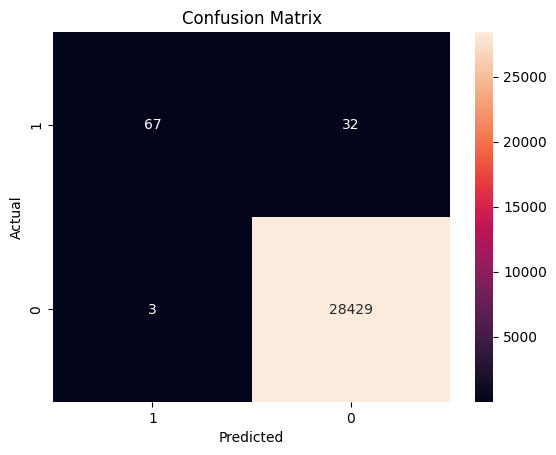

In [17]:
sk_model = SVC(random_state=None)
mlflow.set_experiment("scikit_learn_experiment")
with mlflow.start_run():
    #train(sk_model, x_train, y_train)
    params = {
    "max_iter": 600,
    "C": 1,
    "kernel" : 'poly', # kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’} or callable, default=’rbf’
    }
    mlflow.log_params(params)
    sk_model = sk_model.fit(x_train, y_train)
    train_acc = sk_model.score(x_train, y_train)
    mlflow.log_metric("train_acc", train_acc)
    print(f"Train Accuracy: {train_acc:.3%}")
    evaluate(sk_model, x_test, y_test)
    mlflow.sklearn.log_model(sk_model, "log_reg_model")
    print("Model run: ", mlflow.active_run().info.run_uuid)
mlflow.end_run()

MLFlow will modularize this code so that it will work with the code provided by MLFlow to support implementations of a variety of MLOps principles.

we will notice that Mlflow has created o directory named mlrun in the same directory as your notebook

Now, in the same directory as your notebook type the following in order to start MLFlow UI: 

> mlflow ui -p 1234

the options -p 1234 tell it that you want to host it specifically on the port 1234, if you did not specify a port number then the defalt port is 5000

Then,open a browser and type in http://localhost:1234 or http://127.0.0.1:1234

If it works correctly, you should see something like the figure below:

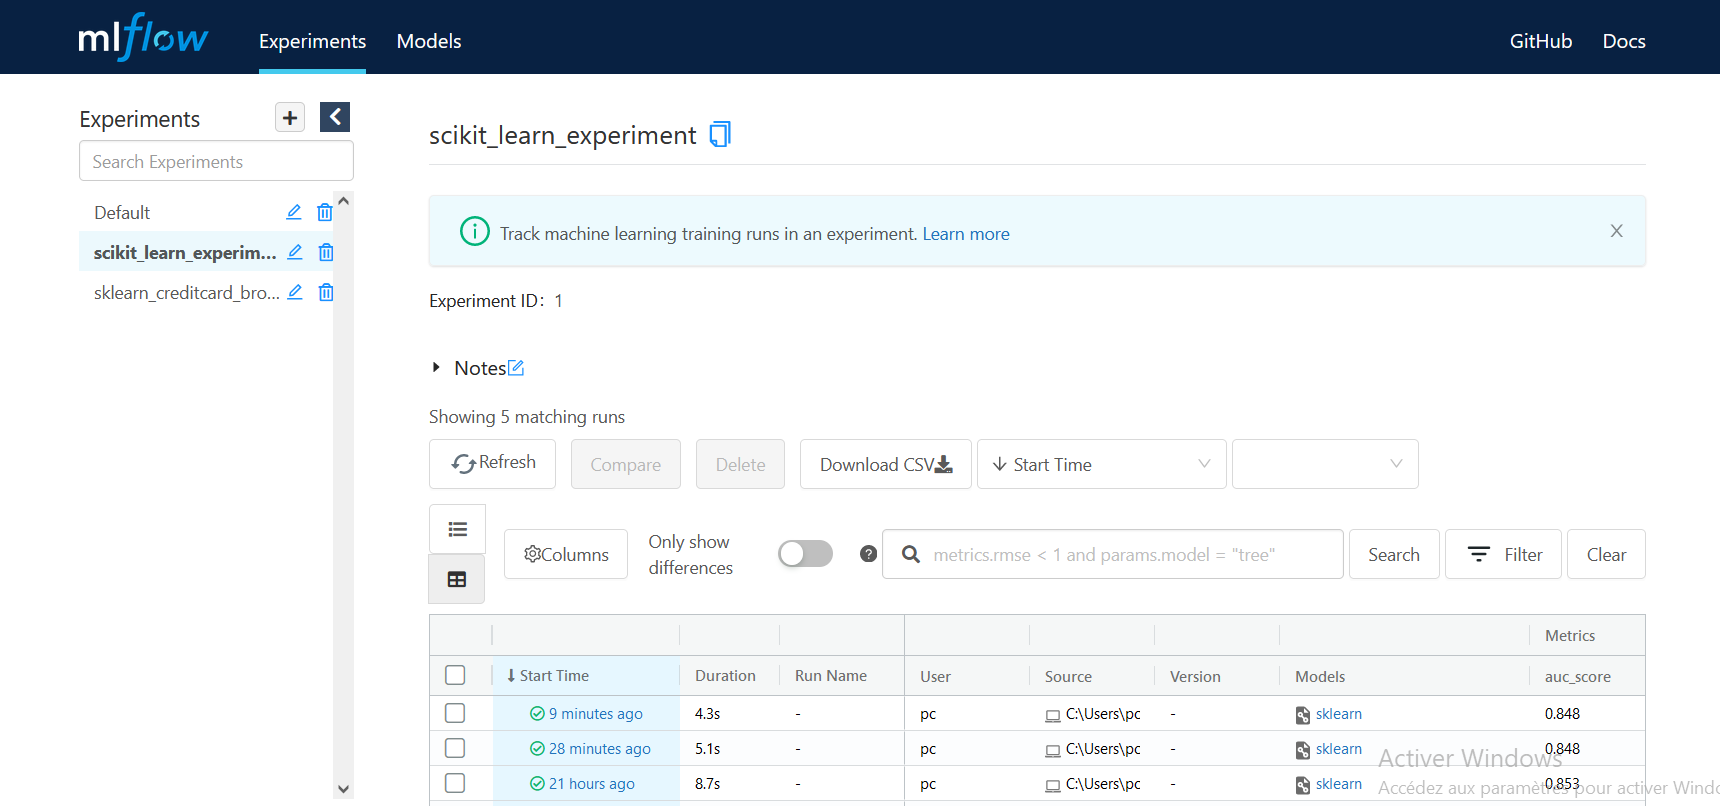


There is 2 expriemnts, the defalut one and the one you just created "scikit_learn_experiment".

Click on it and you will see the runs you just completed 

Click on the run you just created. 

you can see all of the parameters and metrics that were logged. Keep scrolling down and you should be able to see all of the logged artifacts.

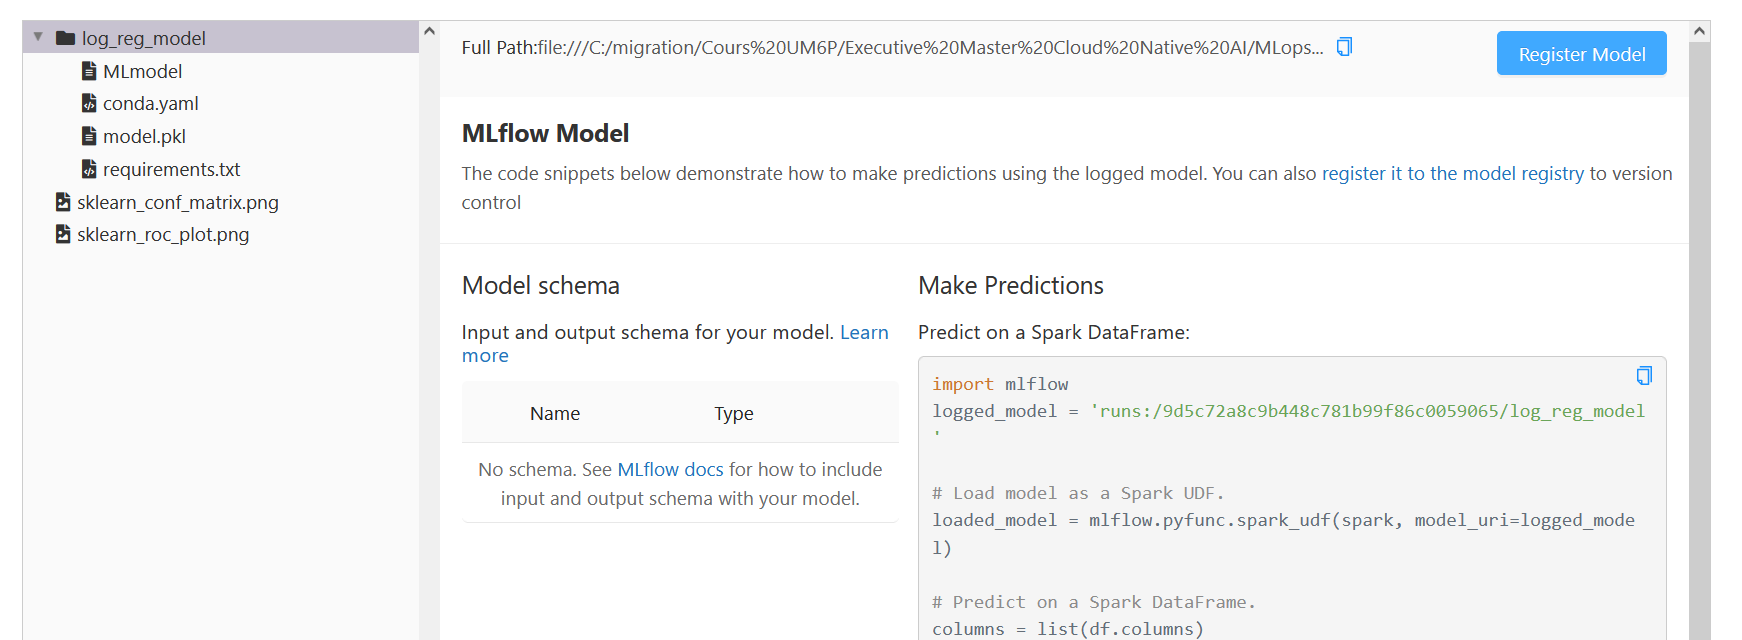

Try to execute a couple times the two cell above (logisticRegression and SVC Runs) and retrun to MLFlow UI and specifically to "scikit_learn_experiment".

**Let's try to compare the metrics of your runs.** 

Select at least 2 runs and click on compare 

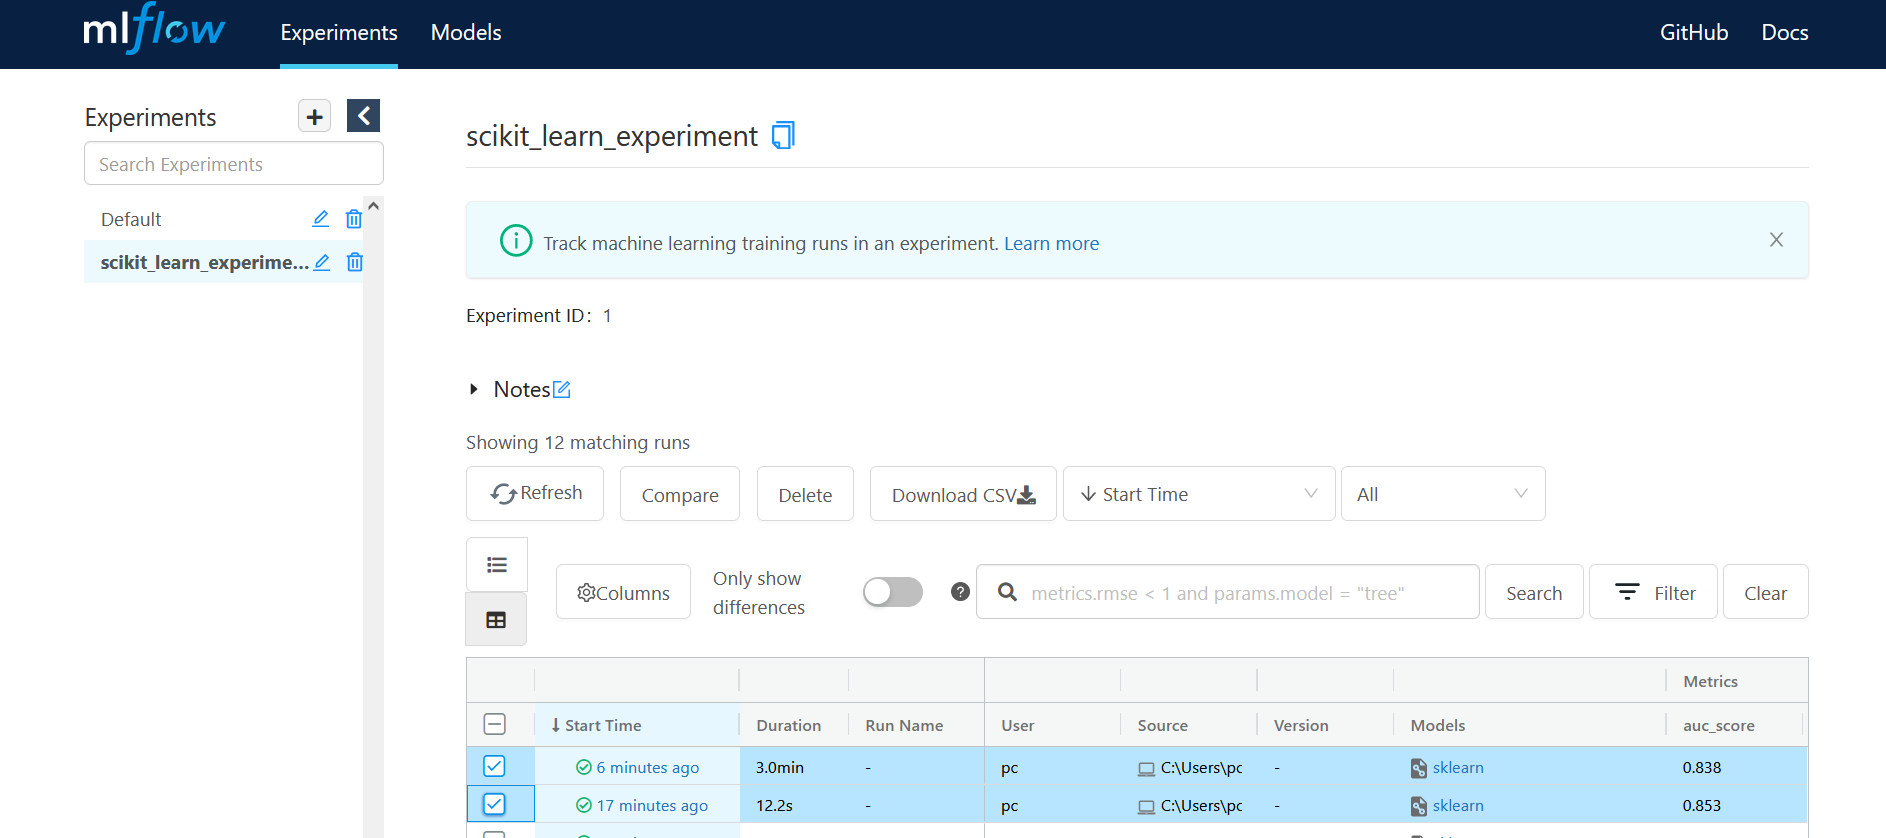

Here, you can directly compare the relevant parameters and metrics between the runs you have chosen. You have the option of viewing a scatter plot, a contour plot, or a parallel coordinates plot.

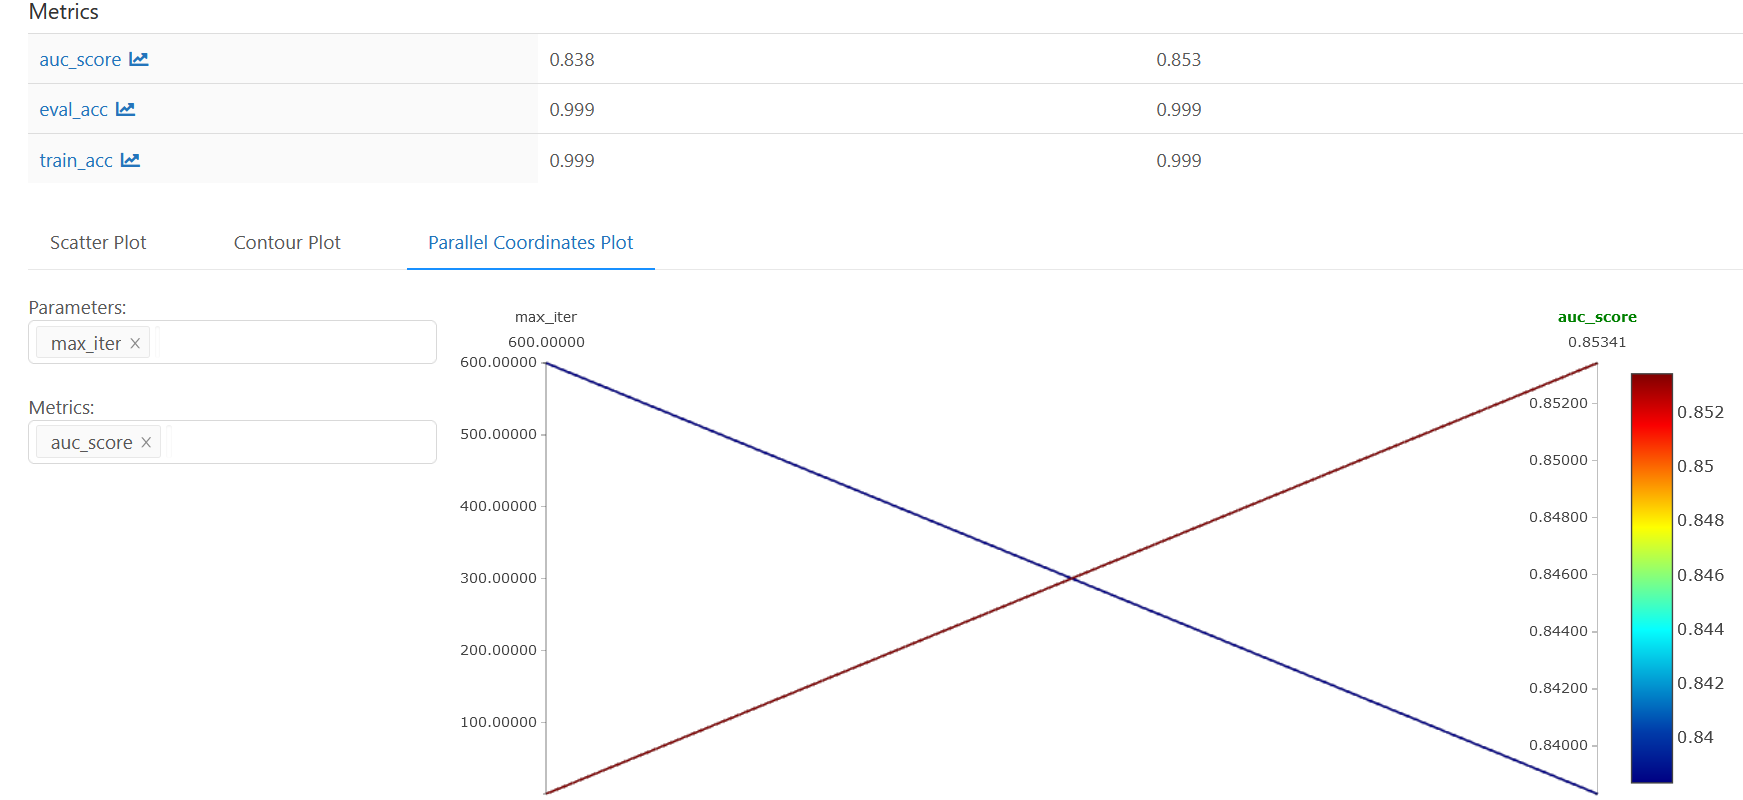

Feel free to play around with these metrics, parameters and with the plots.

you can save these plots.

### Loading a logged model 

Cliquez sur un run et copiez le run ID en haut et exécutez le code suivant avec l'id de votre RUN

In [18]:
loaded_model = mlflow.sklearn.load_model("runs:/5c764a16f0a148b397bd651c80bb0dc8/log_reg_model")

In [19]:
loaded_model.score(x_test, y_test)

0.9987382145736217

### Model validation :parameter tuning with MLflow - Broad search 

L'hyperparamètre que nous souhaitons régler est de combien vous souhaitez pondérer les anomalies par rapport aux points de données normaux. Par défaut, les deux sont pondérés de manière égale. Définissons une liste de poids sur lesquels itérer : 

anomaly_weights = [1, 5, 10, 15] 

In [20]:
anomaly_weights = [1, 5, 10, 15]
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True,random_state=2020)

In [21]:
mlflow.set_experiment("sklearn_creditcard_broad_search")
logs = []
for f in range(len(anomaly_weights)):
    fold = 1
    accuracies = []
    auc_scores= []
    for train, test in kfold.split(x_validate, y_validate):
        with mlflow.start_run():
            weight = anomaly_weights[f]
            mlflow.log_param("anomaly_weight", weight)
            class_weights= {
                0: 1,
                1: weight
            }
            sk_model = LogisticRegression(random_state=None,max_iter=400,solver='newton-cg',class_weight=class_weights).fit(x_validate[train],y_validate[train])
            for h in range(40): print('-', end="")
            print(f"\nfold {fold}\nAnomaly Weight: {weight}")
            train_acc = sk_model.score(x_validate[train],
            y_validate[train])
            mlflow.log_metric("train_acc", train_acc)
            eval_acc = sk_model.score(x_validate[test],
            y_validate[test])
            preds = sk_model.predict(x_validate[test])
            mlflow.log_metric("eval_acc", eval_acc)
            try:
                auc_score = roc_auc_score(y_validate[test], preds)
            except:
                auc_score = -1
            mlflow.log_metric("auc_score", auc_score)
            print("AUC: {}\neval_acc: {}".format(auc_score,
            eval_acc))
            accuracies.append(eval_acc)
            auc_scores.append(auc_score)
            log = [sk_model, x_validate[test],y_validate[test], preds]
            logs.append(log)
            mlflow.sklearn.log_model(sk_model, f"anom_weight_{weight}_fold_{fold}")
            fold = fold + 1
            mlflow.end_run()
    print("\nAverages: ")
    print("Accuracy: ", np.mean(accuracies))
    print("AUC: ", np.mean(auc_scores))
    print("Best: ")
    print("Accuracy: ", np.max(accuracies))
    print("AUC: ", np.max(auc_scores))

2024/01/07 15:32:13 INFO mlflow.tracking.fluent: Experiment with name 'sklearn_creditcard_broad_search' does not exist. Creating a new experiment.


----------------------------------------
fold 1
Anomaly Weight: 1
AUC: 0.8
eval_acc: 0.9985982127212195
----------------------------------------
fold 2
Anomaly Weight: 1
AUC: 0.8568790049001132
eval_acc: 0.998422712933754
----------------------------------------
fold 3
Anomaly Weight: 1
AUC: 0.8406451922461774
eval_acc: 0.9982474588152822
----------------------------------------
fold 4
Anomaly Weight: 1
AUC: 0.8682452129973255
eval_acc: 0.9987732211706976
----------------------------------------
fold 5
Anomaly Weight: 1
AUC: 0.8528532875621686
eval_acc: 0.9989484752891693

Averages: 
Accuracy:  0.9985980161860246
AUC:  0.8437245395411569
Best: 
Accuracy:  0.9989484752891693
AUC:  0.8682452129973255
----------------------------------------
fold 1
Anomaly Weight: 5
AUC: 0.8748241603657465
eval_acc: 0.9987734361310671
----------------------------------------
fold 2
Anomaly Weight: 5
AUC: 0.975398919462244
eval_acc: 0.9982474588152822
----------------------------------------
fold 3
Anomaly

Sur MLFlow UI: Localhost:1234

choisissez l'expérimentation correspondante (sklearn_creditcard_broad_search). 

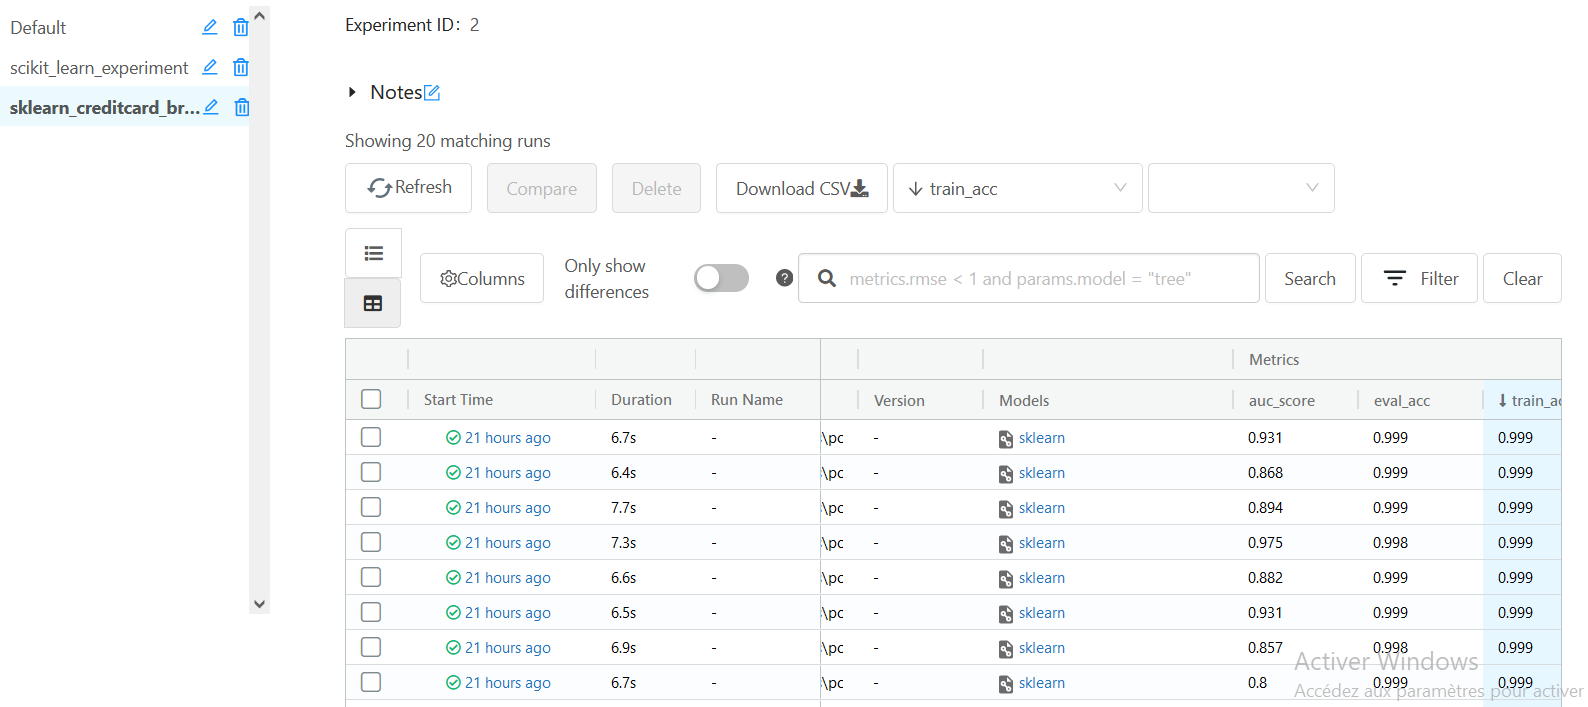

Vous allez maintenant les trier par ordre décroissant pour avoir la meilleur AUC. 

Dans le tableau, cliquez sur auc_score. 

Dans le cas oû vous ne vous souciez vraiment de rien d'autre que des meilleurs scores absolus. supposons que vous ciblez des scores AUC d'au moins 0,90 

l'interface utilisateur fournit une barre de recherche qui effectue une recherche basée sur la clause SQL WHERE. Alors, pour filtrer votre sortie, tapez ce qui suit et cliquez sur Search : 

> metrics."auc_score" >= 0.90

Supposons que vous voulez avoir seulement les runs avec anomaly weight de 5:

> metrics."auc_score" >= 0.90 AND parameters.anomaly_weight = "5"

Le but est de chaoisir le meilleur anomaly weight en prenant en considération l'AUC. 

Essayez d'autres recherches avec d'autres anomaly_weight et en augmentant l'AUC a 0.95

Quel est le meilleur interval pour anomaly_weight ? 

### Model validation :parameter tuning with MLflow - Guided search

Les meilleures performances globales ont été obtenues avec des anomaly weight 5 et 10, mais il semble que la tendance soit à la basse au fur et à mesure que l'on monte avec le poids de l'anomalie.

Copiez le code ci-dessous et collez le en créant un autre nom d'éxperimentation et en commençcant notre recherche à partir de 5 mais cette fois-ci en allant vers le bas.

On peut le voir en comparant les trois meilleurs résultats

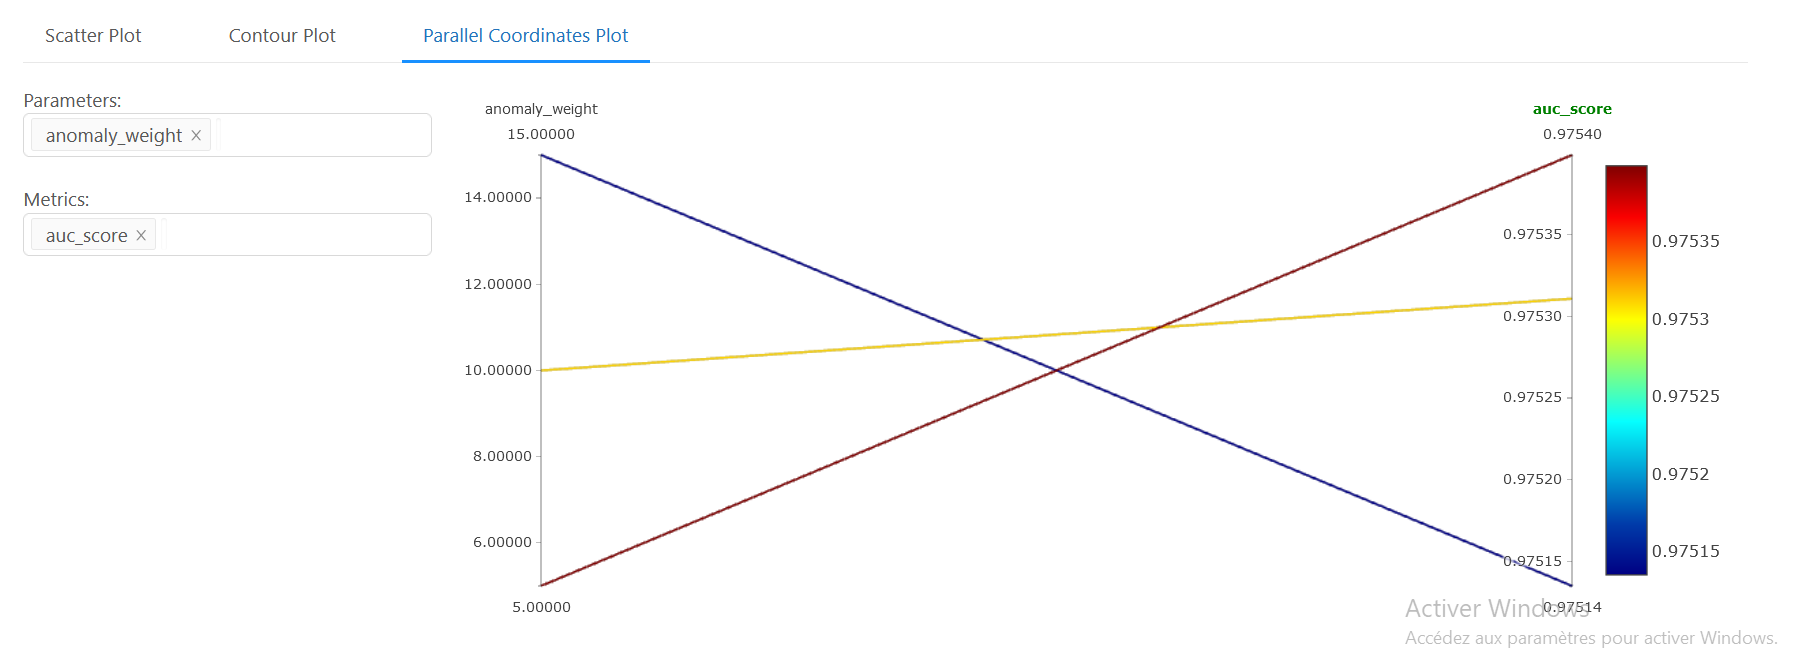

Cahngez les lignes suivantes alors: 

anomaly_weights = [1, 2, 3, 4, 5]

mlflow.set_experiment("sklearn_creditcard_broad_search")


> 1. Alors quel est le meilleur weight ? 

In [22]:
anomaly_weights = [1, 2, 3, 4, 5]


In [23]:
mlflow.set_experiment("sklearn_creditcard_broad_search 1_5")
logs = []
for f in range(len(anomaly_weights)):
    fold = 1
    accuracies = []
    auc_scores= []
    for train, test in kfold.split(x_validate, y_validate):
        with mlflow.start_run():
            weight = anomaly_weights[f]
            mlflow.log_param("anomaly_weight", weight)
            class_weights= {
                0: 1,
                1: weight
            }
            sk_model = LogisticRegression(random_state=None,max_iter=400,solver='newton-cg',class_weight=class_weights).fit(x_validate[train],y_validate[train])
            for h in range(40): print('-', end="")
            print(f"\nfold {fold}\nAnomaly Weight: {weight}")
            train_acc = sk_model.score(x_validate[train],
            y_validate[train])
            mlflow.log_metric("train_acc", train_acc)
            eval_acc = sk_model.score(x_validate[test],
            y_validate[test])
            preds = sk_model.predict(x_validate[test])
            mlflow.log_metric("eval_acc", eval_acc)
            try:
                auc_score = roc_auc_score(y_validate[test], preds)
            except:
                auc_score = -1
            mlflow.log_metric("auc_score", auc_score)
            print("AUC: {}\neval_acc: {}".format(auc_score,
            eval_acc))
            accuracies.append(eval_acc)
            auc_scores.append(auc_score)
            log = [sk_model, x_validate[test],y_validate[test], preds]
            logs.append(log)
            mlflow.sklearn.log_model(sk_model, f"anom_weight_{weight}_fold_{fold}")
            fold = fold + 1
            mlflow.end_run()
    print("\nAverages: ")
    print("Accuracy: ", np.mean(accuracies))
    print("AUC: ", np.mean(auc_scores))
    print("Best: ")
    print("Accuracy: ", np.max(accuracies))
    print("AUC: ", np.max(auc_scores))

2024/01/07 15:34:44 INFO mlflow.tracking.fluent: Experiment with name 'sklearn_creditcard_broad_search 1_5' does not exist. Creating a new experiment.


----------------------------------------
fold 1
Anomaly Weight: 1
AUC: 0.8
eval_acc: 0.9985982127212195
----------------------------------------
fold 2
Anomaly Weight: 1
AUC: 0.8568790049001132
eval_acc: 0.998422712933754
----------------------------------------
fold 3
Anomaly Weight: 1
AUC: 0.8406451922461774
eval_acc: 0.9982474588152822
----------------------------------------
fold 4
Anomaly Weight: 1
AUC: 0.8682452129973255
eval_acc: 0.9987732211706976
----------------------------------------
fold 5
Anomaly Weight: 1
AUC: 0.8528532875621686
eval_acc: 0.9989484752891693

Averages: 
Accuracy:  0.9985980161860246
AUC:  0.8437245395411569
Best: 
Accuracy:  0.9989484752891693
AUC:  0.8682452129973255
----------------------------------------
fold 1
Anomaly Weight: 2
AUC: 0.8249120801828732
eval_acc: 0.9985982127212195
----------------------------------------
fold 2
Anomaly Weight: 2
AUC: 0.9042342002764167
eval_acc: 0.9982474588152822
----------------------------------------
fold 3
Anomal

Les meilleures performances globales ont été obtenues avec des anomaly weight 5 et 4, mais il semble que la tendance soit à la basse au fur et à mesure que l'on monte avec le poids de l'anomalie.
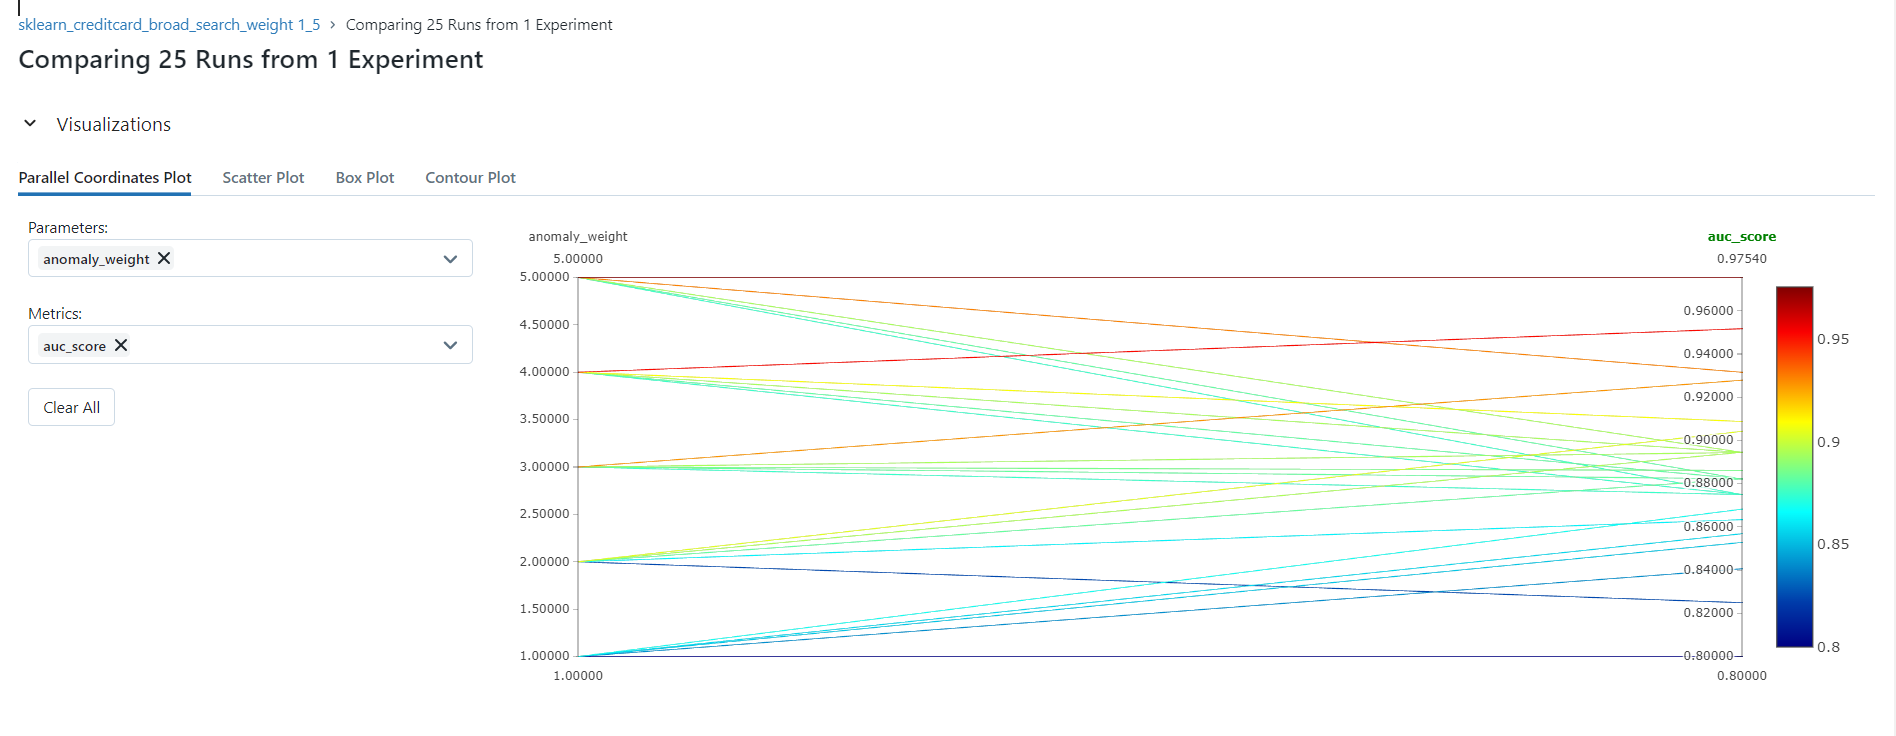